In [1]:
# =======================
# Titanic Initial EDA
# =======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# -----------------------
# Helper function
# -----------------------

def show_plot(X, y=None, size=(6,4)):
    plt.figure(figsize=size)
    sns.violinplot(x=X, y=y, inner="quartile")

In [3]:
# -----------------------
# Load dataset
# -----------------------

data = pd.read_csv('Titanic-Dataset.csv')
data.columns = data.columns.str.lower()
data = data.drop(columns=['passengerid'])
data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# -----------------------
# Split features & target
# -----------------------

X = data.drop(columns=['survived'])
y = data['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# -----------------------
# Separate null and non-null features
# -----------------------

have_null = X_train.columns[X_train.isna().any()].to_list()
msk = ~X_train.columns.isin(have_null)

notna_df = X_train.iloc[:, msk].copy()  # features without nulls
na_df = X_train.iloc[:, ~msk].copy()    # features with nulls

print("Filtered features (no nulls):\n")
notna_df.info()
print("-"*50)
print("Filtered features (with nulls):\n")
na_df.info()

Filtered features (no nulls):

<class 'pandas.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  712 non-null    int64  
 1   name    712 non-null    str    
 2   sex     712 non-null    str    
 3   sibsp   712 non-null    int64  
 4   parch   712 non-null    int64  
 5   ticket  712 non-null    str    
 6   fare    712 non-null    float64
dtypes: float64(1), int64(3), str(3)
memory usage: 44.5 KB
--------------------------------------------------
Filtered features (with nulls):

<class 'pandas.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       575 non-null    float64
 1   cabin     160 non-null    str    
 2   embarked  710 non-null    str    
dtypes: float64(1), str(2)
memory usage: 22.2 KB


In [6]:
# ========================
# Exploratory analysis
# ========================

survived         0         1
pclass                      
1         0.350877  0.649123
2         0.553333  0.446667
3         0.757033  0.242967


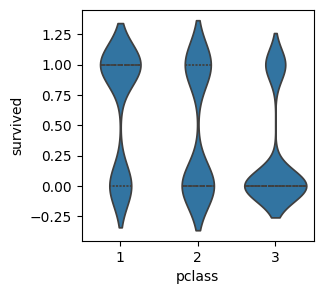

In [7]:
# ----- Pclass -----

print(pd.crosstab(notna_df.pclass, y_train, normalize="index"))
show_plot(notna_df.pclass, y_train, size=(3,3))

class PClassEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = ['pclass_1', 'pclass_3']
    def fit(self, X, y=None):
        if 'pclass' not in X.columns:
            raise ValueError("pclass column not found")
        return self
    def transform(self, X):
        X = X.copy()
        X["pclass_1"] = (X["pclass"] == 1).astype(int)
        X["pclass_3"] = (X["pclass"] == 3).astype(int)
        return X[self.columns]

In [8]:
# ----- Name -----

for name in notna_df.name[:5]:
    print(name.split(','))
    
class NameExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if 'name' not in X.columns:
            raise ValueError("name column not found")
        return self
    def transform(self, X):
        X = X.copy()
        X['title'] = X['name'].str.extract(r',\s*([^.]*)\.')
        X['last_name'] = X['name'].str.extract(r'^([^,]+),')
        return X[['title','last_name']]

['Lam', ' Mr. Ali']
['Frost', ' Mr. Anthony Wood "Archie"']
['Farthing', ' Mr. John']
['Aks', ' Mrs. Sam (Leah Rosen)']
['Collyer', ' Mrs. Harvey (Charlotte Annie Tate)']


survived         0         1
sex                         
female    0.256917  0.743083
male      0.814815  0.185185


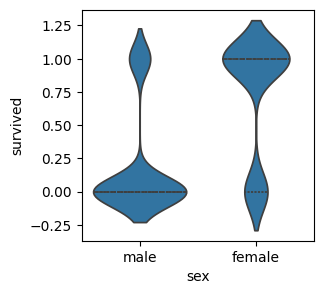

In [9]:
# ----- Sex -----

print(pd.crosstab(notna_df.sex, y_train, normalize="index"))
show_plot(notna_df.sex, y_train, size=(3,3))

class SexEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if 'sex' not in X.columns:
            raise ValueError("sex column not found")
        return self
    def transform(self, X):
        X = X.copy()
        X['is_male'] = (X['sex'] == 'male').astype(int)
        return X[['is_male']]

survived         0         1
sibsp                       
0         0.655870  0.344130
1         0.463415  0.536585
2         0.476190  0.523810
3         0.900000  0.100000
4         0.800000  0.200000
5         1.000000  0.000000
8         1.000000  0.000000


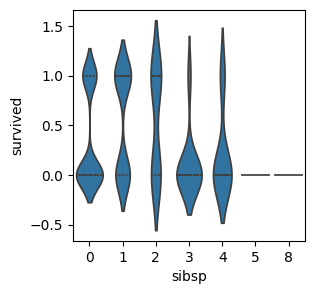

In [10]:
# ----- SibSp -----

print(pd.crosstab(notna_df.sibsp, y_train, normalize="index"))
show_plot(notna_df.sibsp, y_train, size=(3,3))

class SibspBinning(BaseEstimator, TransformerMixin):
    def _bining_helper(self, x):
        if x == 0: return 'alone'
        elif x <= 2: return 'small'
        else: return 'large'
    def fit(self, X, y=None):
        if 'sibsp' not in X.columns:
            raise ValueError("sibsp column not found")
        return self
    def transform(self, X):
        X = X.copy()
        X['bin_sibsp'] = X['sibsp'].apply(self._bining_helper)
        return X[['bin_sibsp']]

survived         0         1
parch                       
0         0.658672  0.341328
1         0.457447  0.542553
2         0.459016  0.540984
3         0.400000  0.600000
4         1.000000  0.000000
5         0.800000  0.200000
6         1.000000  0.000000


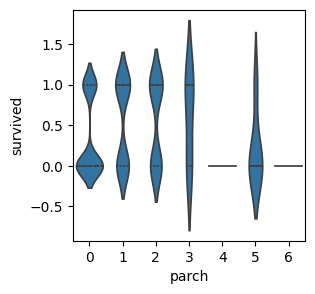

In [11]:
# ----- Parch -----

print(pd.crosstab(notna_df.parch, y_train, normalize="index"))
show_plot(notna_df.parch, y_train, size=(3,3))

class ParchBinning(BaseEstimator, TransformerMixin):
    def _bining_helper(self, x):
        if x == 0: return 'alone'
        elif 1 <= x <= 2: return 'small'
        else: return 'large'
    def fit(self, X, y=None):
        if 'parch' not in X.columns:
            raise ValueError("parch column not found")
        return self
    def transform(self, X):
        X = X.copy()
        X['bin_parch'] = X['parch'].apply(self._bining_helper)
        return X[['bin_parch']]

In [12]:
# ----- Ticket -----

for ticket in notna_df.ticket[:5]:
    print(ticket.split(' '))

class TicketExtractorAdvanced(BaseEstimator, TransformerMixin):
    def __init__(self, top_k=10):
        self.top_k = top_k
        self.top_prefixes_ = None
    def fit(self, X, y=None):
        if 'ticket' not in X.columns:
            raise ValueError("ticket column not found")
        prefixes = X['ticket'].str.extract(r'^([a-z./]+)', expand=False).fillna('none')
        self.top_prefixes_ = prefixes.value_counts().head(self.top_k).index.tolist()
        return self
    def transform(self, X):
        X = X.copy()
        X['ticket_prefix'] = X['ticket'].str.extract(r'^([a-z./]+)', expand=False).fillna('none')
        X['ticket_prefix'] = X['ticket_prefix'].apply(lambda x: x if x in self.top_prefixes_ else 'rare')
        X['ticket_number'] = X['ticket'].str.extract(r'(\d+)$', expand=False).astype(float).fillna(0)
        return X[['ticket_prefix','ticket_number']]

['1601']
['239854']
['PC', '17483']
['392091']
['C.A.', '31921']


In [ ]:
# ----- Fare -----

bining = pd.qcut(notna_df['fare'], q=4, labels=['Q1','Q2','Q3','Q4'], duplicates='drop')
print(pd.crosstab(bining, y_train, normalize="index"))

class FareBinning(BaseEstimator, TransformerMixin):
    def __init__(self, method='quantile', bins=None, labels=None, q=4):
        self.method = method
        self.bins = bins
        self.labels = labels
        self.q = q
        self.bin_edges_ = None
    def fit(self, X, y=None):
        if 'fare' not in X.columns:
            raise ValueError("fare column not found")
        if self.method == 'manual':
            if self.bins is None: raise ValueError("bins must be provided")
            self.bin_edges_ = self.bins
        elif self.method == 'quantile':
            self.bin_edges_ = np.unique(X['fare'].quantile(np.linspace(0,1,self.q+1)))
        else:
            raise ValueError("method must be 'manual' or 'quantile'")
        if self.labels is None:
            self.labels_ = [f'Bin{i+1}' for i in range(len(self.bin_edges_)-1)]
        else:
            self.labels_ = self.labels
        return self
    def transform(self, X):
        X = X.copy()
        X['fare_bin'] = pd.cut(X['fare'], bins=self.bin_edges_, labels=self.labels_, include_lowest=True)
        return X[['fare_bin']]

# ----- Age -----
bining = pd.qcut(na_df['age'], q=4, labels=['Q1','Q2','Q3','Q4'], duplicates='drop')
print(pd.crosstab(bining, y_train, normalize="index"))

class AgeImmputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if 'age' not in X.columns: raise ValueError("age column not found")
        self.mean = X['age'].mean()
        return self
    def transform(self, X):
        X = X.copy()
        X['age'] = X['age'].fillna(self.mean)
        return X[['age']]

# ----- Embarked -----
print(pd.crosstab(na_df.embarked, y_train, normalize="index"))
show_plot(na_df.embarked, y_train, size=(3,3))

class EmbarkedEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        if 'embarked' not in X.columns: raise ValueError("embarked column not found")
        self.mode_ = X['embarked'].mode()[0]
        return self
    def transform(self, X):
        X = X.copy()
        X['embarked'] = X['embarked'].fillna(self.mode_)
        X['is_S'] = (X['embarked']=='S').astype(int)
        return X[['is_S']]